# Binary Classification EP vs VGP
October 2017, 
> Run in Docker tensorflow/tensorflow:1.3.0-py3,

> GPflow git commit e71fe63fa333adcd7f9138feeb647fd442fed1e9

Binary classification is hard with GPs due to the non Gaussian likelihood. Therefore approximations need to be made. This notebook shows how one can use an EP approximation for this task and compares it to the VGP approximation. We will begin by describing how EP works for GP classification. We give a very short introductions so for further details please see Chapter 3 of Rasmussen, C.E. and Williams, C.K.  (2006). For details on VGP please see the seperate notebook.



## The problem of GP classification

For predicting at new points with a GP we need to evaluate the following integral:
$$
p(f_\ast|X, \mathbf{x_\ast}, \mathbf{y}) = \int p(f_\ast|X, \mathbf{x_\ast}, \mathbf{f}) p(\mathbf{f}, X, \mathbf{y}) d\mathbf{f}
$$

Where the right hand term inside the integral is proportional to:

$$
 p(\mathbf{f}, \mathbf{y}| X) \propto p(\mathbf{y}|\mathbf{f}) p(\mathbf{f}| X)
$$

It is the non-Gaussian likelihood, $p(\mathbf{y}|\mathbf{f})$, that causes us problems.
Note that the likelihood factorizes over training cases so we can be expressed as:

$$ 
\prod p(y_i|f_i)
$$
And for classification we may often use the standard Gaussian cdf, 
$$
\phi(t) = \int^t_{-\infty} \mathcal{N}(x; 0, 1) dx
$$
to represent the likelihood (ie for each $p(y_i|f_i)$).

## Solution via EP
EP approximates each likelihood factor with an unormalised Gaussian, ie:
$$
p(\mathbf{f}|X)\prod_i p(y_i|f_i) \approx p(\mathbf{f}| X) \prod_i \tilde{Z_i} \mathcal{N}(f_i; \tilde{\mu_i}. \tilde{\sigma_i}^2)
$$
The resulting expression of this product of Gaussian is an unormalised Gaussian. Note that we can marginalise out $\mathbf{f}$ and get the marginal likelihood, $p(\mathbf{y}|X)$, which can be used as an objective when optimising the GP's hyperparameters.

We are now left to find these these three site parameters, $\tilde{Z_i} , \tilde{\mu_i}. \tilde{\sigma_i}^2$, for each datapoint. EP does this through an iterative procedure where one improves each approximating factor one by one. One first removes the approximating factor correpsonding to one datapoint (and so creates the cavity distribution) and then one swaps in the true factor that we are trying to approximate (in our case the Gaussian CDF). One then tries to update the site parameters by finding a new approximation factor that when recombined back with the cavity distribution it "matches" the cavity plus true factor distribution as best as possible. This _"matching"_ is done via minimising the KL divergence (from the true distribution to the approximate distribution), which for the Gaussian approximation factors involves matching moments. Having found a better approximation factor for that datapoint this is combined with the cavity distribution to create a new posterior for the latent function. The same steps are then done for the next datapoint.

This process repeats several times (ie an outer loop over the inner loop over datapoints) until the site parameters converge. (Note that we actually run parallel EP so that the inner loop is parallelised).


## Demonstration using GPflow

We compare VGP and EPBinGP (EP for binary classifier GP) using GPflow. We first import the modules we need, load a dataset to compare on and create plotting functions.

In [1]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf

import numpy as np

import gpflow
from gpflow_external_models import ep_approximated_like
# ^ note in here we have written an extension class to GPflow that can use its EP tools for 
# finding the likelihood approximation factors.

Xtrain = np.loadtxt('data/banana_X_train', delimiter=',')
Ytrain = np.loadtxt('data/banana_Y_train', delimiter=',').reshape(-1,1)


def gridParams():
    mins = [-3.25, -2.85]
    maxs = [3.65, 3.4]
    nGrid = 50
    xspaced = np.linspace(mins[0], maxs[0], nGrid)
    yspaced = np.linspace(mins[1], maxs[1], nGrid)
    xx, yy = np.meshgrid(xspaced, yspaced)
    Xplot = np.vstack((xx.flatten(), yy.flatten())).T
    return mins, maxs, xx, yy, Xplot


def plot(m, ax):
    col1 = '#0172B2'
    col2 = '#CC6600'
    mins, maxs, xx, yy, Xplot = gridParams()
    p, _ = m.predict_y(Xplot)
    ax.plot(Xtrain[:, 0][Ytrain[:, 0] == 1], Xtrain[:, 1][Ytrain[:, 0] == 1], 'o', color=col1,
            mew=0, alpha=0.5)
    ax.plot(Xtrain[:, 0][Ytrain[:, 0] == 0], Xtrain[:, 1][Ytrain[:, 0] == 0], 'o', color=col2,
            mew=0, alpha=0.5)
    if hasattr(m, 'Z'):
        ax.plot(m.Z.value[:, 0], m.Z.value[:, 1], 'ko', mew=0, ms=4)

    if np.min(p) < -0.1:
        lin = np.linspace(-1., 1., 10)
        print("classification between -1 and 1 so using 10 levels between 0 and 10")
    else:
        lin = np.linspace(0., 1., 10)  # this should be the case but have if just in case.
    ax.contour(xx, yy, p.reshape(*xx.shape), lin, colors='k', linewidths=1.8, zorder=100)
    ax.set_title("{}".format(type(m)))


We now create the plots and run both models:

Running VGP model.
VGP model's initial model log likelihood: -397.63106416405304
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 106.670094
  Number of iterations: 101
  Number of functions evaluations: 106
VGP model's final model log likelihood: -106.67009355469196
VGP model's final kernel variance: 14.520677820829109
VGP model's final kernel lengthscale: 0.796852188569577


Running Binary EP Classification Model
Number iterations pre optimisation for EP convergence 5
EPBinGP model's initial model log likelihood: -148.37775237789666
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 106.375612
  Number of iterations: 16
  Number of functions evaluations: 24
Number iterations post optimisation for EP convergence 16
EPBinGP model's final model log likelihood: -106.37561200304083
EPBinGP model's final kernel variance: 15.

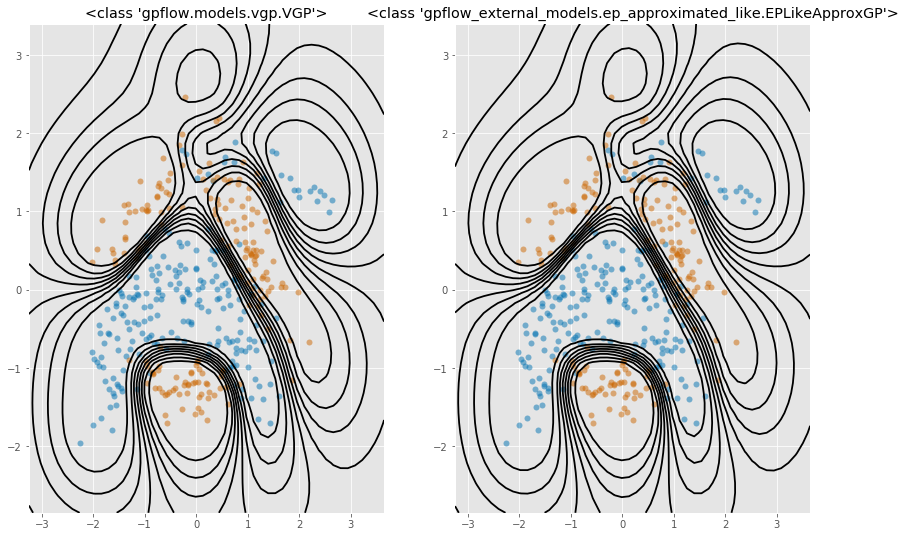

In [2]:
f, axarr = plt.subplots(1, 2, figsize=(14, 9))

# VGP Model:
print("Running VGP model.")
m = gpflow.models.VGP(Xtrain, Ytrain,
                            kern=gpflow.kernels.RBF(2),
                            likelihood=gpflow.likelihoods.Bernoulli())
m.compile()
print("VGP model's initial model log likelihood: {}".format(m.compute_log_likelihood()))
gpflow.train.ScipyOptimizer(options=dict(maxiter=100)).minimize(m)
plot(m, axarr[0])
print("VGP model's final model log likelihood: {}".format(m.compute_log_likelihood()))
print("VGP model's final kernel variance: {}".format(m.kern.variance.read_value()))
print("VGP model's final kernel lengthscale: {}".format(m.kern.lengthscales.read_value()))
print("=================================\n\n")

# And EP model:
print("Running Binary EP Classification Model")
sess = tf.Session()
m2 = ep_approximated_like.EPLikeApproxGP(Xtrain, Ytrain, kern=gpflow.kernels.RBF(2),
                                         likelihood=gpflow.likelihoods.Bernoulli(),
                                         use_cache_on_like=False)
m2.compile(session=sess)
tau_tilde, nu_tilde, num_iter = m2.run_ep()
print("Number iterations pre optimisation for EP convergence {}".format(num_iter))
print("EPBinGP model's initial model log likelihood: {}".format(m2.compute_log_likelihood()))
gpflow.train.ScipyOptimizer(options=dict(maxiter=100)).minimize(m2)
tau_tilde, nu_tilde, num_iter = m2.run_ep()
print("Number iterations post optimisation for EP convergence {}".format(num_iter))
plot(m2, axarr[1])
print("EPBinGP model's final model log likelihood: {}".format(m2.compute_log_likelihood()))
print("EPBinGP model's final kernel variance: {}".format(m2.kern.variance.read_value()))
print("EPBinGP model's final kernel lengthscale: {}".format(m2.kern.lengthscales.read_value()))
print("=================================\n\n")
plt.show()

There are a few things to note from this:
1. The EP run took far longer than VGP. That was because we run EP at each optimisation step. This takes time as a while loop is run whilst EP converges. If the site parameters do not change that much in between evaluations then one can tell the classifier to not calculate the site parameters at each step by setting `use_cache_on_like` to True. This should speed it up.
2. The initial model log likelihood for the EP model is much higher than VGP. This is because the initial hyperparameters are okay for this parameter and EP does not have inducing points that it needs to optimise. See also how the optimiser needed a only 16 iterations for the EP approximation compared to 101 for the VGP model.
3. The final log likelihoods for the two models are very close. For VGP it is a lower bound whereas for EP it is only an approximation.



We see both plots look fairly identical and both classifiers have done a good job at finding a solution.

We can see how the optimisation of these two models changes with time and also when the ADAM (Kingma, D. and Ba, J., 2014). Let's start again and rerun the VGP model plotting the classification boundary every 100 steps. We will also time each 100 steps

Beginning work on the VGP model
Time from start is 3.653921127319336 and step: 0 done!
Time from start is 7.089111566543579 and step: 1 done!
Time from start is 10.429288864135742 and step: 2 done!
Time from start is 13.822815656661987 and step: 3 done!
Time from start is 17.302598476409912 and step: 4 done!
Time from start is 20.60638451576233 and step: 5 done!
Time from start is 23.92171549797058 and step: 6 done!
Time from start is 27.241201400756836 and step: 7 done!
Time from start is 30.699931621551514 and step: 8 done!
Time from start is 34.06253170967102 and step: 9 done!
Beginning work on the EP model
Time from start is 10.797231912612915 and step: 0 done!
Time from start is 21.40735149383545 and step: 1 done!
Time from start is 32.27807807922363 and step: 2 done!
Time from start is 42.85707402229309 and step: 3 done!
Time from start is 53.25448822975159 and step: 4 done!
Time from start is 63.94121861457825 and step: 5 done!
Time from start is 74.48867559432983 and step: 6 do

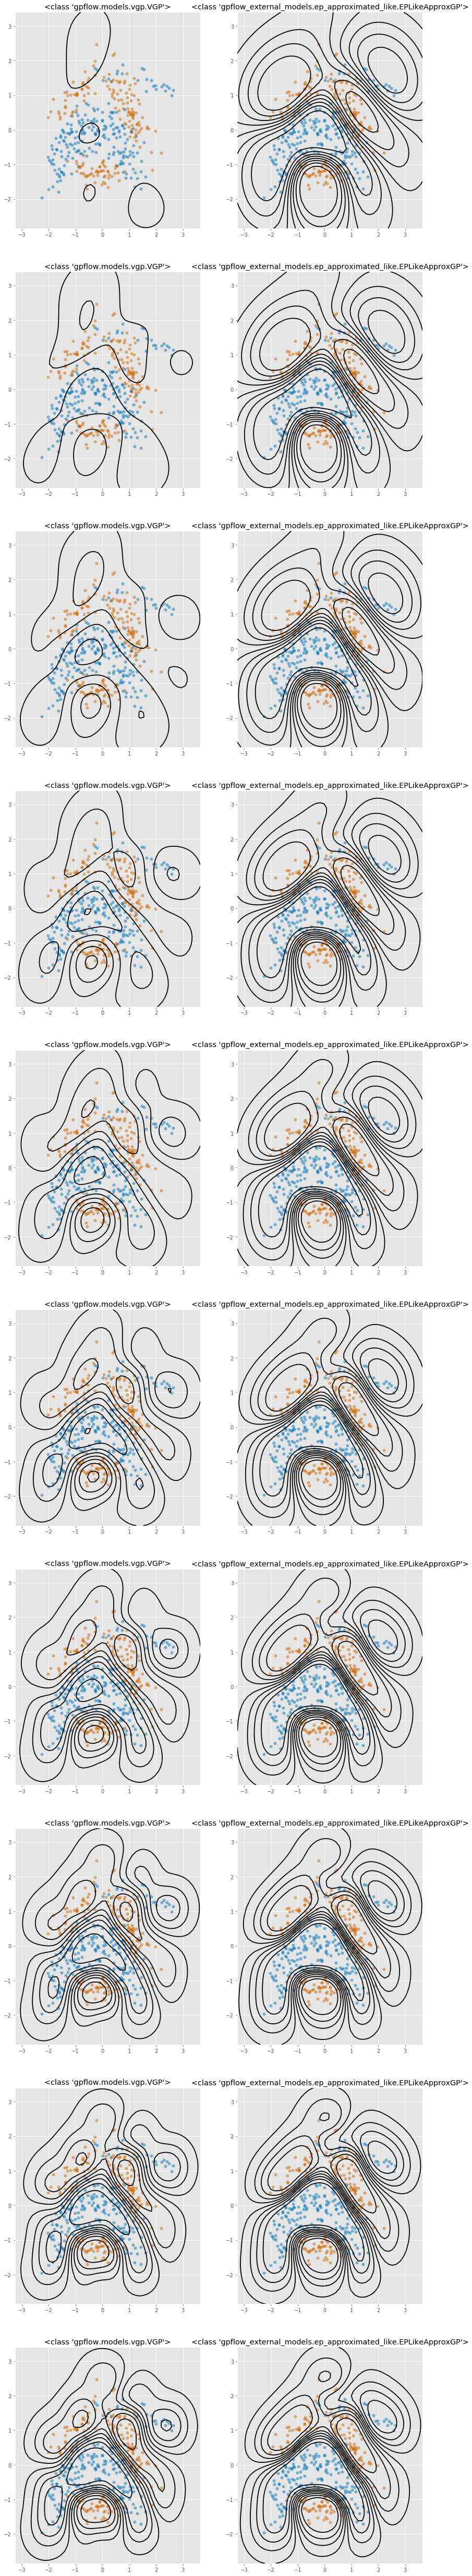

In [3]:
import time 

print("Beginning work on the VGP model")
num_rows = 10
new_graph = tf.Graph()
sess = tf.Session(graph=new_graph)
f, axarr = plt.subplots(num_rows, 2, figsize=(14, 9*num_rows))  # 10 rows now
m_vgp2 = gpflow.models.VGP(Xtrain, Ytrain,
                                kern=gpflow.kernels.RBF(2),
                                likelihood=gpflow.likelihoods.Bernoulli())
m_vgp2.compile(sess)
time_start = time.time()
with new_graph.as_default():
    adam_optimiser = gpflow.train.AdamOptimizer()
for i in range(num_rows):
    adam_optimiser.minimize(m_vgp2, maxiter=100, session=sess)
    plot(m_vgp2, axarr[i, 0])
    print("Time from start is {} and step: {} done!".format(time.time() - time_start, i))
    

    
# EP model
print("Beginning work on the EP model")
new_graph2 = tf.Graph()
sess = tf.Session(graph=new_graph2)
m_ep2 = ep_approximated_like.EPLikeApproxGP(Xtrain, Ytrain, kern=gpflow.kernels.RBF(2),
                                             likelihood=gpflow.likelihoods.Bernoulli(),
                                             use_cache_on_like=True)
# ^ now we're going to use the cache on the factors as otherwise it will be very slow
m_ep2.compile(session=sess)
tau_tilde, nu_tilde, num_iter = m_ep2.run_ep()
with new_graph2.as_default():
    adam_optimiser = gpflow.train.AdamOptimizer()
time_start = time.time()
for i in range(num_rows):
    adam_optimiser.minimize(m_ep2, maxiter=100, session=sess)
    # We will now update the EP parameters as they may become stale
    m_ep2.clear_ep_params()
    tau_tilde, nu_tilde, num_iter = m_ep2.run_ep()
    plot(m_ep2, axarr[i, 1])
    print("Time from start is {} and step: {} done!".format(time.time() - time_start, i))



See how when measured by time per step the EP model takes much longer, but as a function of number of steps the solution it finds converges much faster than the VGP approach. It does not have an inducing point distribution to train so the optimisation is easier.